# 1.1 Feature Selection

- 1.1.1 Factor Analysis
- 1.1.2 Mutual Information
- 1.1.3 Decision Trees

In [45]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [46]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
from research.strings import TARGET, PREDICTORS, INSPECTORS, OTHER_PREDICTORS

In [48]:
data = pd.read_csv("data/train_data.csv")
data[[TARGET] + PREDICTORS].head()

,criticalFound,Inspector_blue,Inspector_brown,Inspector_green,Inspector_orange,Inspector_purple,Inspector_yellow,pastSerious,pastCritical,timeSinceLast,ageAtInspection,consumption_on_premises_incidental_activity,tobacco_retail_over_counter,temperatureMax,heat_burglary,heat_sanitation,heat_garbage
0,0.0,0,0,1,0,0,0,0.0,0.0,2.0,1,0.0,1.0,53.496667,26.992376,37.748787,12.768572
1,0.0,1,0,0,0,0,0,0.0,0.0,2.0,1,0.0,0.0,59.046667,13.976557,15.412267,12.895485
2,0.0,1,0,0,0,0,0,0.0,0.0,2.0,1,0.0,0.0,59.046667,12.611239,8.320330,8.004220
3,0.0,1,0,0,0,0,0,0.0,0.0,2.0,1,0.0,0.0,56.153333,35.906383,38.186618,26.238645
4,0.0,1,0,0,0,0,0,0.0,0.0,2.0,1,0.0,0.0,52.730000,9.530785,2.126788,3.401567


In [49]:
X = data[PREDICTORS]
y = data[TARGET]
X.shape

(17075, 16)

## 1.1.1 Factor Analysis

In [65]:
from sklearn.decomposition import FactorAnalysis

# Code from: https://stackoverflow.com/questions/41388997/factor-analysis-in-sklearn-explained-variance

def fa_var_explained(fa):
    m = fa.components_
    n = fa.noise_variance_
    m1 = m**2
    m2 = np.sum(m1,axis=1)
    var_explained = m2 / (np.sum(m2) + np.sum(n))
    return var_explained

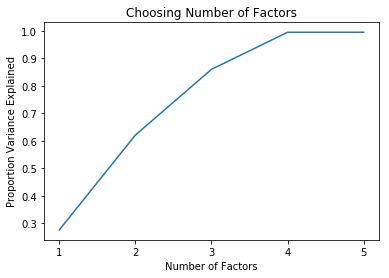

In [66]:
nc_vals = list(range(1, 6))
var_exp = np.zeros(len(nc_vals))
for i, nc in enumerate(nc_vals):
    fa = FactorAnalysis(n_components=nc, random_state=0)
    fa.fit(X)
    var_exp[i] = fa_var_explained(fa).sum()
sns.lineplot(x=nc_vals, y=var_exp)
plt.xticks(nc_vals)
plt.xlabel("Number of Factors")
plt.ylabel("Proportion Variance Explained")
plt.title("Choosing Number of Factors")
plt.show()

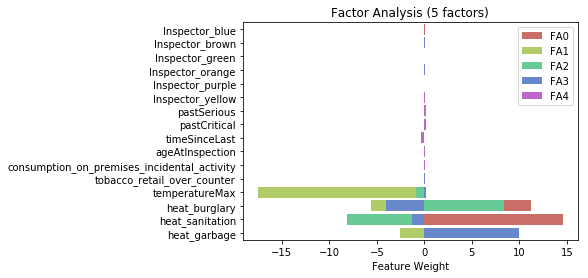

In [67]:
n_factors = 5
fa = FactorAnalysis(n_components=n_factors, random_state=0)
fa.fit(X)
colors = sns.color_palette("hls", len(fa.components_))
for i in range(len(fa.components_)):
    sns.barplot(
        x=fa.components_[i], y=PREDICTORS,
        color=colors[i], label="FA{}".format(i)
    )
plt.legend()
plt.xlabel("Feature Weight")
plt.title("Factor Analysis ({} factors)".format(n_factors))
plt.show()

## 1.1.2 Mutual Information

In [69]:
DISCRETE = [
    'Inspector_blue',
    'Inspector_brown',
    'Inspector_green',
    'Inspector_orange',
    'Inspector_purple',
    'Inspector_yellow',
    'pastSerious',
    'pastCritical',
    'consumption_on_premises_incidental_activity',
    'tobacco_retail_over_counter'
]
discrete_idx = [PREDICTORS.index(d) for d in DISCRETE]

In [70]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X, y, discrete_features=discrete_idx, random_state=0)

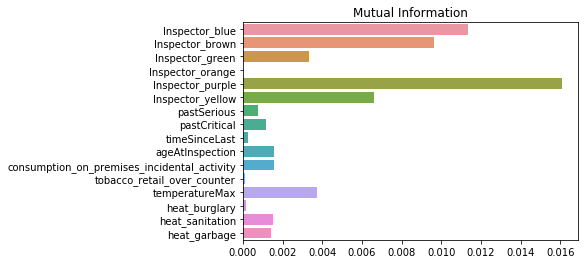

In [71]:
ax = sns.barplot(x=mi, y=PREDICTORS)
plt.title("Mutual Information")
plt.show()

## 1.1.3 Decision Trees

In [92]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from research.evaluation import evaluate_model, visualize_tree
import pickle

In [96]:
df = pd.DataFrame(data.copy())
df["Inspector"] = df[INSPECTORS].idxmax(axis=1).apply(lambda x: str(x)[10:])
le = LabelEncoder()
df["InspectorColor"] = le.fit_transform(df["Inspector"])
features = ["InspectorColor"] + OTHER_PREDICTORS
X_cat = df[features]
y_cat = df[TARGET]
X_cat.head()

,InspectorColor,pastSerious,pastCritical,timeSinceLast,ageAtInspection,consumption_on_premises_incidental_activity,tobacco_retail_over_counter,temperatureMax,heat_burglary,heat_sanitation,heat_garbage
0,2,0.0,0.0,2.0,1,0.0,1.0,53.496667,26.992376,37.748787,12.768572
1,0,0.0,0.0,2.0,1,0.0,0.0,59.046667,13.976557,15.412267,12.895485
2,0,0.0,0.0,2.0,1,0.0,0.0,59.046667,12.611239,8.320330,8.004220
3,0,0.0,0.0,2.0,1,0.0,0.0,56.153333,35.906383,38.186618,26.238645
4,0,0.0,0.0,2.0,1,0.0,0.0,52.730000,9.530785,2.126788,3.401567


In [97]:
CLASSES = ["No Critical", "Critical Found"]
COLORS = ["#57D2DB", "#DB5E56"]
feature_codes = ["F{}".format(i) for i in range(len(features))]
for code, feat in zip(feature_codes, features):
    print("{}\t{}".format(code, feat))

F0	InspectorColor
F1	pastSerious
F2	pastCritical
F3	timeSinceLast
F4	ageAtInspection
F5	consumption_on_premises_incidental_activity
F6	tobacco_retail_over_counter
F7	temperatureMax
F8	heat_burglary
F9	heat_sanitation
F10	heat_garbage


In [98]:
df_train, df_test = train_test_split(
    df, stratify=y, test_size=0.25, random_state=0
)
X_train = df_train[features]
X_test = df_test[features]
y_train = df_train[TARGET]
y_test = df_test[TARGET]
print("Train: N = {0}, P(CriticalFound|X) = {1:.3f}".format(len(X_train), y_train.mean()))
print("Test:  N = {0}, P(CriticalFound|X) = {1:.3f}".format(len(X_test), y_test.mean()))

Train: N = 12806, P(CriticalFound|X) = 0.141
Test:  N = 4269, P(CriticalFound|X) = 0.141


In [99]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
evaluate_model(y_test, tree.predict(X_test))

F1 Score = 0.22204
Precision = 0.22112
Recall = 0.22296


,Predicted +,Predicted -
Actual +,134,467
Actual -,472,3196


In [100]:
clf = pickle.load(open("models/sklearn-glm.pkl", "rb"))
evaluate_model(y_test, clf.predict(df_test[PREDICTORS]))

F1 Score = 0.03190
Precision = 0.38462
Recall = 0.01664


,Predicted +,Predicted -
Actual +,10,591
Actual -,16,3652


In [114]:
tree_depth = 7
tree_lim = DecisionTreeClassifier(max_depth=tree_depth, random_state=0)
tree_lim.fit(X_train, y_train)
evaluate_model(y_test, tree_lim.predict(X_test))

F1 Score = 0.06107
Precision = 0.37037
Recall = 0.03328


,Predicted +,Predicted -
Actual +,20,581
Actual -,34,3634


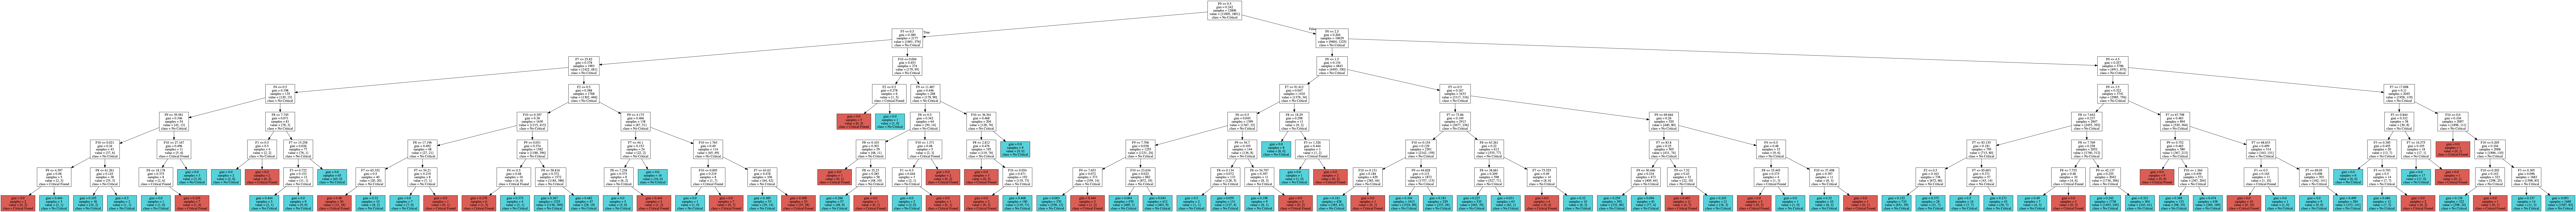

In [117]:
im = visualize_tree(tree_lim, feature_codes, CLASSES, COLORS)
imfile = "figures/tree_height_{}.png".format(tree_depth)
with open(imfile, "wb") as file:
    file.write(im.data)
im